In [2]:
#IMPORT BLOCK
# general
import pandas as pd
import numpy as np

import itertools

#plot
import matplotlib.pyplot as plt
import seaborn as sns

#gen ml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

#nn/keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input

#metrics
from sklearn.metrics import mean_squared_error

#hyperparameter tuning
from sklearn.model_selection import GridSearchCV
import keras_tuner as kt


import files

In [3]:
# fasta file reading
def read_fasta(file_path):
    with open(file_path, 'r') as file:
        sequences = [line.strip() for line in file if not line.startswith(">")]
    return pd.DataFrame(sequences, columns=["Sequence"])

In [4]:
bound = read_fasta('/Users/peytonhall/Documents/spring_2025/qbio_465/assignment_3/max_bound.fasta')
bound

,Sequence
0,AGAGCAAGTGTAAGTTCTTAGGCGCTCGAG
1,ACAGAATTAACTGCGGGCATCGCAAACCTG
2,GTTAACTCTGCATAACTCATTTTAGATGTT
3,TCCTGAATCTCGTCTGGACTAGGGACACTT
4,GAGCAAAAGGAAACTCAAAACATTGCTTCG
...,...
1995,TAGCATTGTCAACCTTGTGAGTACAGCGAC
1996,TATTAGGGATGGACACGTGCAATAACTGCC
1997,AAAATGATTTAAGCCGGAAGAGTAAGGTGA
1998,CAGACAGGCGTGCCACCAGCCGAAGTGCTG


In [5]:
unbound = read_fasta('/Users/peytonhall/Documents/spring_2025/qbio_465/assignment_3/max_unbound.fasta')
unbound

,Sequence
0,TCAACTTAGAGGGCACGTGGCGATCATATA
1,TACAGACTAGATTCACCCGAATAGTACCGA
2,CCATGCACTAAACCAGGTGTACGCTGAGAG
3,TGTCGACGTCAATCACGAGGGAGAGATACT
4,TCCAATAATAGGGCACACGGATAAAGGGGG
...,...
1995,ACCCGAGATCAGTCACGTGAACACAAAAAT
1996,ATATACCCCCAGGCACGTGGCATCGAGGTT
1997,TGGGGTATGTAACCAAGGGTCTAATGATGA
1998,TTAGGGCAGCAACCACGTGAGTCAACGATC


In [6]:
file_path = '/Users/peytonhall/Documents/spring_2025/qbio_465/assignment_3/Max.txt'
max_data = pd.read_csv(file_path, sep='\t', header=None)
max_data.columns = ['sequence', 'binding_strength']
max_data

,sequence,binding_strength
0,GAAGCCCTGGCGGGGCGCGTGCCCGCCGCCGCCGCC,3.737829
1,TCCCGGGGCTAGAGGCATGTGGACTCAGGAGGATGA,3.895754
2,GGCGCTGCCGGACTGCGCGTGGAGTGGCGCGCTGCT,3.797545
3,GCAGCTCGCCCGGGCCACGCGGTGCCGGCCCTCGGC,4.080446
4,GGAATTACCTTCATCCACATGGTTGAAGCTGGCTGG,4.126748
...,...,...
8563,AGCAAAGCTGGCCCCCACGTTGTCCTTCCGCAGAAC,4.010130
8564,GGGACCCTGCCTTCCCGCGTGGCCGCACCGAGACGA,4.036789
8565,AGAAGAACCCGGGCGCACGTGGCCGACTCCAGGCTG,4.418053
8566,GGGGCCCGGGTGGGGCATGTGGGGACAACGCCTGGA,3.939968


Q1: Deep Learning Model for Regression Using Keras [1pts]
1.  Build a fully connected neural network (NN) using Keras that:

● Uses the 1-mer one-hot encoding as input (use the encoding function from the
previous assignment).

● Has one hidden layer with 16 nodes and ReLU activation.

● Uses Mean Squared Error (MSE) as the loss function.

● Uses Adam as the optimizer.

● Trains for 50 epochs.

In [7]:
# encode 1mer 
# Function: k_mer_encode
# Parameters: sequence and k for k-mer(1,2,3,4)
# returns: array of encoded seq with k as k-mer
def k_mer_encode(seq, k):
    # possible nt
    nt= ["A", "C", "T", "G"]
    
    # permutation/enumerate
    k_mers= {''.join(kmer) : i for i, kmer in enumerate(itertools.product(nt, repeat=k))}
    
    # matrix
    identity_matrix= np.identity(4**k)
    
    # encode
    encoding= [identity_matrix[k_mers[seq[i: i+k]]] for i in range(len(seq)-k+1)]
    return np.concatenate(encoding)

In [8]:
sequence = max_data["sequence"]
affinity = max_data["binding_strength"]

In [9]:
# scale affinity 
# min-max normalization function
def normalizationFunct(shape):
    minShape = np.min(shape, axis=0)  # Minimum for each column
    maxShape = np.max(shape, axis=0)  # Maximum for each column
    y = (shape - minShape) / (maxShape - minShape)
    return y

In [10]:
y = normalizationFunct(affinity)

In [11]:
X = np.array([k_mer_encode(i,1) for i in sequence])

In [12]:
y.shape

(8568,)

In [13]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# neural network
model = Sequential()
#one hidden layer with 16 nodes and ReLU activation
model.add(Input(shape= np.array(X_train).shape[1:], ))
model.add(Dense(16, activation='relu'))

# compile with adam optimizer and mse as loss
model.compile(optimizer=Adam(), loss='mse')

2. Train the model and evaluate it using MSE on the test set.

In [15]:
# train the model w 50 epochs
history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=50, 
                    batch_size=64,
                    verbose=1)

Epoch 1/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1451 - val_loss: 0.1074
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - loss: 0.0874 - val_loss: 0.0324
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - loss: 0.0232 - val_loss: 0.0091
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - loss: 0.0083 - val_loss: 0.0065
Epoch 5/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - loss: 0.0066 - val_loss: 0.0060
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - loss: 0.0063 - val_loss: 0.0062
Epoch 7/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - loss: 0.0062 - val_loss: 0.0059
Epoch 8/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - loss: 0.0063 - val_loss: 0.0059
Epoch 9/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - loss: 0.0062 - val_loss: 0.0060
Epoch 10/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step - loss: 0.0064 - val_loss: 0.0062
Epoch 11/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - loss: 0.0068 - val_loss: 0.0059
Epoch 12/50
108/108 ━━━━━━━━━━━━

Plot the learning history of the NN (training vs. validation loss over epochs).

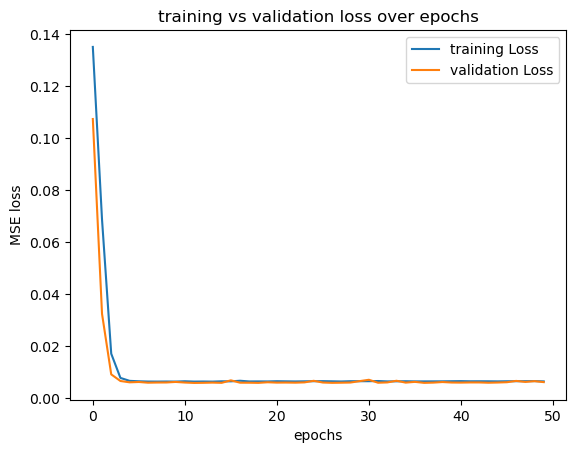

In [16]:
# plot learning history
plt.plot(history.history['loss'], label='training Loss')
plt.plot(history.history['val_loss'], label='validation Loss')
plt.xlabel('epochs')
plt.ylabel('MSE loss')
plt.legend()
plt.title('training vs validation loss over epochs')
plt.show()

# Q2: Comparison of Deep Learning Model with Linear Regression model
[2pts]

1. Train three separate linear regression models, one for each of the following k-mer
representations:
    
● 1-mer encoding

● 2-mer encoding

● 3-mer encoding

In [17]:
def lin_regress(seq,affinity):
    # split data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(seq, affinity, test_size=0.2, random_state=22)
    
    # initialize model
    model = LinearRegression()
    
    # fit model
    model.fit(X_train, y_train)
    
    # make predictions on training and testing data
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # train and test loss via mse
    mse_train_loss = mean_squared_error(y_train, train_pred)
    mse_test_loss = mean_squared_error(y_test, test_pred)
    
    return mse_train_loss, mse_test_loss

In [18]:
#1mer was made, called X from above
train_loss_mono, test_loss_mono = lin_regress(X,y)

In [19]:
#make 2mer
di_mer = np.array([k_mer_encode(i,2) for i in sequence])

In [20]:
#make 3mer
tri_mer = np.array([k_mer_encode(i,3) for i in sequence])

In [21]:
train_loss_di, test_loss_di = lin_regress(di_mer,y)

In [22]:
train_loss_tri, test_loss_tri = lin_regress(tri_mer,y)

In [23]:
#var to store nn 1mer mse test
nn_50_val = history.history['val_loss']

In [24]:
test_loss_nn = nn_50_val[-1]

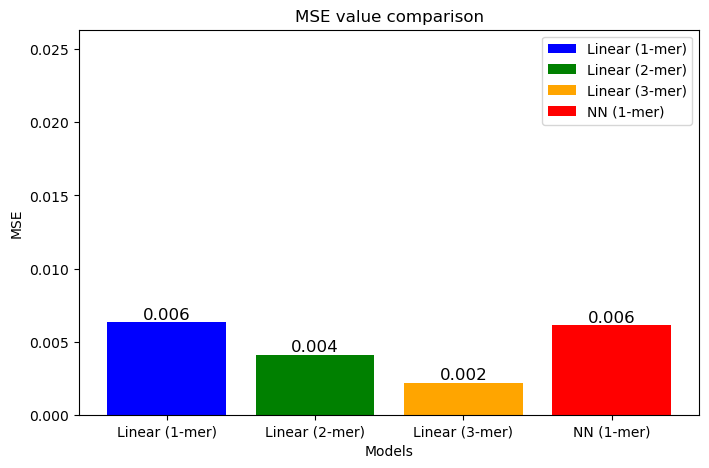

In [25]:
mse_values = [test_loss_mono, test_loss_di, test_loss_tri, test_loss_nn]
model_names = ["Linear (1-mer)", "Linear (2-mer)", "Linear (3-mer)", "NN (1-mer)"]
colors = ['blue', 'green', 'orange', 'red']

#bar plot
plt.figure(figsize=(8, 5))
bars = plt.bar(range(4), mse_values, color=colors)

#add MSE values on top of bars
for bar, mse in zip(bars, mse_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{mse:.3f}", 
             ha='center', va='bottom', fontsize=12)

#formatting
plt.xlabel("Models")
plt.ylabel("MSE")
plt.title("MSE value comparison")
plt.xticks(range(4), model_names)  

# add legend
plt.legend(bars, model_names, loc="upper right")

plt.ylim(0, max(mse_values) + 0.02)
plt.show()


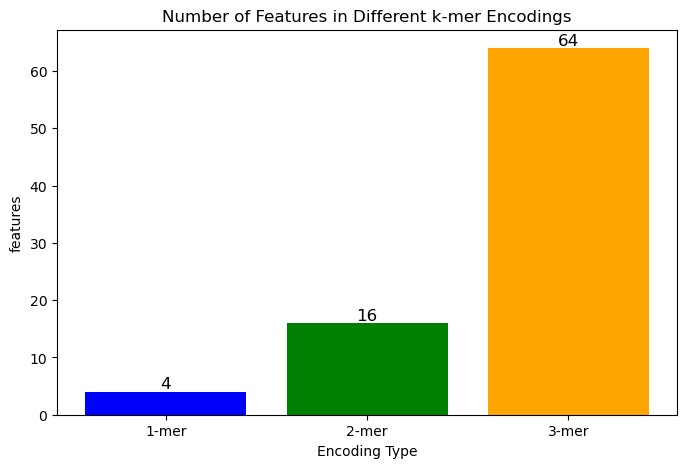

In [26]:
feature_counts = [4, 16, 64]  
encoding_types = ["1-mer", "2-mer", "3-mer"]
colors = ['blue', 'green', 'orange']

#plot
plt.figure(figsize=(8, 5))
bars = plt.bar(encoding_types, feature_counts, color=colors)

#add feature count
for bar, count in zip(bars, feature_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{count}", 
             ha='center', va='bottom', fontsize=12)

#formatting
plt.xlabel("Encoding Type")
plt.ylabel("features")
plt.title("Number of Features in Different k-mer Encodings")

plt.show()

Effect of k on Linear Regression: How does increasing k affect linear regression
performance? Based on Bar Plot 2, what could be the possible disadvantages of using
linear regression for higher k-mer values?

Increasing k improves linear regression performance. However, the possible disadvantage of using linear regression for higher k-mer values is overfitting, which could result from more data and so, more noise. 

Deep Learning vs. Linear Regression: Does the neural network outperform all three
linear regression models? Explain your findings and discuss the potential advantages or
disadvantages of using deep learning for this task based on the observed results.

The neural network does not outperform all three linear regression models. It seems that it performs the same as linear regression for 1-mer. This suggests that the added complexity of the nn does not provide significant benefits in this case. 

# Q3: Improving Deep Learning Model with Hyperparameter Tuning [3 pts]

In this task, you will start with the initial NN model you created in Q2 (one hidden layer, 16
nodes) and then optimize it using hyperparameter tuning. The goal is to find the
best-performing model and compare it with the regression models. The hyperparameter
search may require a long execution time.

1. Tune the following hyperparameters:
    
● Number of hidden layers: [1, 2, 3]
    
● Nodes per layer: [16, 64, 128]
    
● Batch size: [8, 32, 256]
    
● Batch normalization: [Yes, No]
    
● Dropout rate: [0, 0.1, 0.5, 0.9]

In [27]:
X_train_df = pd.DataFrame(X_train)
y_train_df = pd.DataFrame(y_train)

In [28]:
print(X_train_df.shape)
print(y_train_df.shape)
X_train_df.index

(6854, 144)
(6854, 1)


RangeIndex(start=0, stop=6854, step=1)

In [30]:
y_train_df.index

Index([3621, 6829, 4335, 8424, 1188, 5715, 4714, 8235,  447, 2698,
       ...
       8322, 5578, 4426,  466, 6265, 5734, 5191, 5390,  860, 7270],
      dtype='int64', length=6854)

2. To reduce execution time, perform hyperparameter search using only 20% of the training
data, randomly selected instead of the full training dataset, and run 20 epochs for each
search.

In [31]:
# drop for alignment, kept getting issue w index not being found in y 
X_train_df = X_train_df.reset_index(drop=True)
y_train_df = y_train_df.reset_index(drop=True)

# get 20%
X_train_2 = X_train_df.sample(frac=0.2, random_state=42)
# use same index for features
y_train_2 = y_train_df.loc[X_train_2.index]  

In [34]:
# check to make dure indices line up 
print(X_train_2.index)
print(y_train_2.index)

Index([ 469, 3855, 4776, 3027, 4635, 5338, 2900, 4523, 1393, 3235,
       ...
       2795, 1543, 4322, 4679, 5642, 5045, 3734, 6334,  641, 5624],
      dtype='int64', length=1371)
Index([ 469, 3855, 4776, 3027, 4635, 5338, 2900, 4523, 1393, 3235,
       ...
       2795, 1543, 4322, 4679, 5642, 5045, 3734, 6334,  641, 5624],
      dtype='int64', length=1371)


In [35]:
# function: build_model
# parameters: hyperparameter
# returns: modelw optimal hp
def build_model(hp):
    model = Sequential()
    
    # Number of hidden layers: [1, 2, 3]
    hidden_layers = hp.Int('hidden_layers', min_value=1, max_value=3, step=1)
    
    # Nodes per layer: [16, 64, 128]
    for _ in range(hidden_layers):
        model.add(Dense(
            units=hp.Choice('units', values=[16, 64, 128]),  
            activation='relu'
        ))

    # batch normalization(yes,no)
    if hp.Boolean('batch_norm'):
        model.add(BatchNormalization())
    
    # Dropout rate: [0, 0.1, 0.5, 0.9]
    model.add(Dropout(rate=hp.Choice('dropout', values=[0.0, 0.1, 0.5, 0.9])))
    
    # Output layer (1 unit for regression)
    model.add(Dense(1))
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='mse')
    return model

In [36]:
# tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    # store the data of each trial
    max_epochs=20,
    factor=3,
    #hyperband_iterations=1,
    directory='keras_tuner_results',
    project_name='hyperparameter_tuning'
)

# tuner search
tuner.search(X_train_2, y_train_2, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Get best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("best hyperparameters:", best_hyperparameters.values)

# evaluate best model on test data
final_predictions = best_model.predict(X_test)
final_mse = mean_squared_error(y_test, final_predictions)
print("final MSE with best hyperparametrers", final_mse)

Reloading Tuner from keras_tuner_results/hyperparameter_tuning/tuner0.json
best hyperparameters: {'hidden_layers': 2, 'units': 128, 'batch_norm': False, 'dropout': 0.5, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0015'}
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step
final MSE with best hyperparametrers 0.005844042649006581


/Users/peytonhall/miniconda3/envs/qbio_490_pbhall/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


3. Report the best parameters found from the hyperparameter search.

The best parameters found from the hp search was 2 hidden layers, 128 nodes per layer, no batch normalization, and a dropout rate of 0.5. 

In [37]:
trials = tuner.oracle.trials.values()

# store the data of each trial
trial_data = []

# iterate + collect hyperparameters and validation loss 
for trial in trials:
    trial_params = trial.hyperparameters.values  # Get hyperparameters for the trial
    
    # pull for box plot
    relevant_params = {
        'hidden_layers': trial_params['hidden_layers'],
        'nodes': trial_params['units'],
        'batch_norm': trial_params['batch_norm'],
        'dropout': trial_params['dropout']
    }
    
    # get val loss history then min val loss
    val_loss_history = trial.metrics.get_history('val_loss') 
    val_loss = trial.score
#     val_loss=min([i.value for i in val_loss_history])
    
    # Append hyperparameters and val loss to trial_data
    #trial_data.append(list(relevant_params.values()) + [val_loss])
    trial_data.append([relevant_params['hidden_layers'], relevant_params['nodes'], 
                       relevant_params['batch_norm'], relevant_params['dropout'], 
                       val_loss])
    
# define cols for the df
columns = ['hidden_layers', 'units', 'batch_norm', 'dropout', 'val_loss']
# results_df
results_df = pd.DataFrame(trial_data, columns=columns)

In [38]:
print(trial.hyperparameters.values)

{'hidden_layers': 3, 'units': 128, 'batch_norm': False, 'dropout': 0.1, 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [39]:
print(results_df.head())
print(results_df.dtypes)

   hidden_layers  units  batch_norm  dropout  val_loss
0              2     16       False      0.9  0.085021
1              1     16       False      0.1  0.033511
2              2    128       False      0.5  0.021202
3              2    128       False      0.1  0.015469
4              1    128       False      0.9  0.047452
hidden_layers      int64
units              int64
batch_norm          bool
dropout          float64
val_loss         float64
dtype: object


In [52]:
results_df

,hidden_layers,units,batch_norm,dropout,val_loss
0,2,16,False,0.9,0.085021
1,1,16,False,0.1,0.033511
2,2,128,False,0.5,0.021202
3,2,128,False,0.1,0.015469
4,1,128,False,0.9,0.047452
5,3,16,True,0.9,0.041767
6,3,64,True,0.9,0.102177
7,1,16,True,0.1,0.056390
8,3,64,False,0.1,0.020312
9,3,128,True,0.1,0.025452


4. Report the best parameters found from the hyperparameter search.
Create Box Plot 1: Show model performance for different hyperparameter settings. The
x-axis represents the hyperparameters, and the y-axis represents MSE. The same type
of hyperparameters should have the same box color or be highlighted clearly for
better readability.

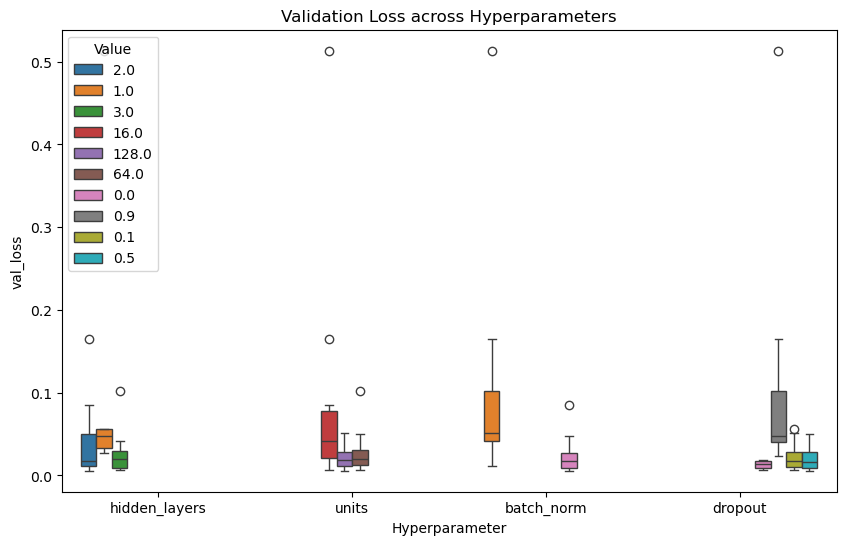

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# combine df to have hyperparam against value 
melted_df = results_df.melt(id_vars=['val_loss'], 
                            value_vars=['hidden_layers', 'units', 'batch_norm', 'dropout'], 
                            var_name='Hyperparameter', 
                            value_name='Value')

# categorical variables to strings for proper grouping
melted_df['Value'] = melted_df['Value'].astype(str)

# plotting
plt.figure(figsize=(10, 6))
sns.boxplot(x='Hyperparameter', y='val_loss', hue='Value', data=melted_df)
plt.title("Validation Loss across Hyperparameters")
plt.legend(title="Value", loc='upper left') 
plt.show()

5. With the best parameters, rebuild the model using the full training data.

In [46]:

# pull best hyperparams to rebuild
rebuilt_model = tuner.hypermodel.build(best_hyperparameters)

# train the model on the full data 
history = rebuilt_model.fit(X_train_2, y_train_2, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1552 - val_loss: 0.0276
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0440 - val_loss: 0.0242
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0341 - val_loss: 0.0207
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0311 - val_loss: 0.0184
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0217 - val_loss: 0.0158
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0194 - val_loss: 0.0143
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0145 - val_loss: 0.0126
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0147 - val_loss: 0.0120
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0131 - val_loss: 0.0111
Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0112 - val_loss: 0.0110
Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0113 - val_loss: 0.0100
Epoch 12/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0098 - val_lo

In [47]:
final_val_loss = history.history['val_loss'][-1]

6. Extend Bar Plot 1 to include the best deep learning model along with the other four
models.

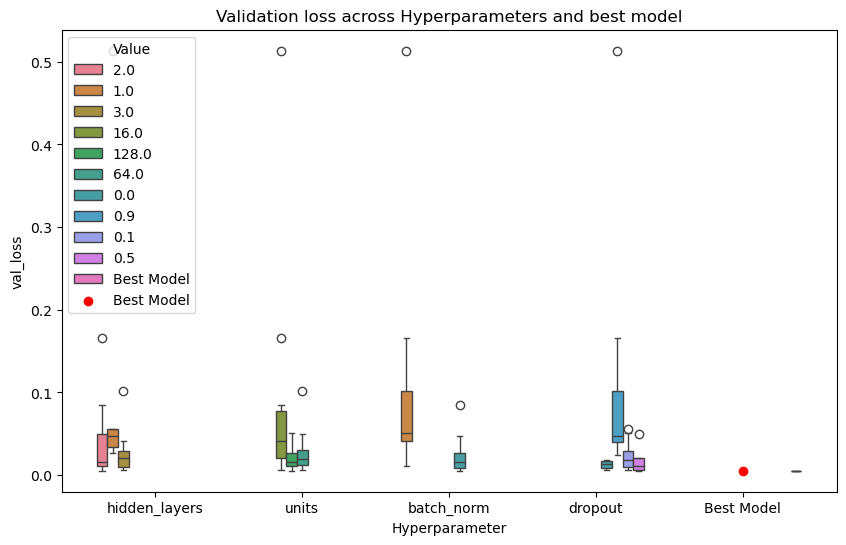

In [64]:
# dict to hold hp 
best_model_data = {
    'hidden_layers': best_hyperparameters['hidden_layers'],
    'units': best_hyperparameters['units'],
    'batch_norm': best_hyperparameters['batch_norm'],
    'dropout': best_hyperparameters['dropout'],
    'val_loss': final_val_loss
}

# dict to dataframe 
best_model_df = pd.DataFrame([best_model_data])

# append best model data to results df
final_df = pd.concat([results_df, best_model_df], ignore_index=True)

# melt again for plotting
melt_2_df = final_df.melt(id_vars=['val_loss'], 
                            value_vars=['hidden_layers', 'units', 'batch_norm', 'dropout'], 
                            var_name='Hyperparameter', 
                            value_name='Value')

#melt_2_df['Value'] = melt_2_df['Value'].astype(str)

# Now, add the best model as a separate row for plotting
best_model_row = pd.DataFrame([{
    'Hyperparameter': 'Best Model', 
    'val_loss': final_val_loss, 
    'Value': 'Best Model'  
}])

#new df
melt_3_df = pd.concat([melt_2_df, best_model_row], ignore_index=True)

# plotting
plt.figure(figsize=(10, 6))
sns.boxplot(x='Hyperparameter', y='val_loss', hue='Value', data=melt_3_df)

# add in dot using scatter to indicate best model loss
plt.scatter(x=['Best Model'] * len(best_model_row), y=[final_val_loss] * len(best_model_row), color='red', label='Best Model', zorder=10)

plt.title("Validation loss across Hyperparameters and best model")
plt.legend(title="Value", loc='upper left')
plt.show()

In [ ]:
# converted vars to categorical, so 0 is no, 1 is yes for batch norm

Hyperparameters significantly improve performance based on Box plot 1. From the box plot, I observe the highest loss resulting from a hidden layer of 1, a node count of 16, dropout of 0.9, with batch normalization. This may be due to a lack of complexity in the model form the low node and hidden layer counts, and the high dropout may result in less features and so, underfitting because the model has less data to learn from and so, cannot build strong representations of the data. On the other hand, increased hidden layers and nodes decrease loss and increase performance by allowing the model to become more complex and so, to better account for the complexities and patterns in the data. 

Yes, the deep learning models improved and outperformed the other linear regression models. After using the optimal hyperparameters, the best model had a minimum loss of 0.023, which was lower than most of the linear regression models. The initial neural network had a loss of 0.6, so there was a significant improvement due to hyperparameter tuning. 